## Исследовательский анализ данных

#### Импорт и изучение данных

In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

try:
    data_arc = pd.read_csv('/datasets/final_steel/data_arc.csv')
    data_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
    data_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
    data_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
    data_temp = pd.read_csv('/datasets/final_steel/data_temp.csv')
    data_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
    data_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')
except:
    data_arc = pd.read_csv('final_steel/data_arc.csv')
    data_bulk = pd.read_csv('final_steel/data_bulk.csv')
    data_bulk_time = pd.read_csv('final_steel/data_bulk_time.csv')
    data_gas = pd.read_csv('final_steel/data_gas.csv')
    data_temp = pd.read_csv('final_steel/data_temp.csv')
    data_wire = pd.read_csv('final_steel/data_wire.csv')
    data_wire_time = pd.read_csv('final_steel/data_wire_time.csv')

Так как нас интересует предсказание температуры стали (то есть финального продукта), в `data_temp` оставим только значения последнего по времени измерения для каждой партии, избавившись при этом от пропусков там, где данные последнего измерения отсутствуют (будь то по причине ошибки в работе оборудования или же, возможно, если партию забраковали на каком-то из предыдущих этапов и в финальный продукт она не пошла). 

Также в отдельный признак выделим начальное (то есть первое измеренное) значение температуры для каждой партии.

In [2]:
print('Информация о данных с целевым признаком до обработки:')
display(data_temp.head())
display(data_temp.info())
display(data_temp.describe())

data_temp_first = data_temp
data_temp_time_first = data_temp.groupby('key')['Время замера'].min()
data_temp_first = data_temp_first[data_temp_first['Время замера'].isin(data_temp_time_first)].reset_index(drop=True).dropna()
data_temp_first = data_temp_first.rename(columns={"Температура": "Начальная температура"})
data_temp_first = data_temp_first.drop(columns=['Время замера'])

data_temp_time_last = data_temp.groupby('key')['Время замера'].max()
data_temp= data_temp[data_temp['Время замера'].isin(data_temp_time_last)].reset_index(drop=True).dropna()
data_temp = data_temp.drop(columns=['Время замера'])
data_temp = data_temp.merge(data_temp_first, on='key', how='left')

print('Количество уникальных значений номеров партий c указанным целевым признаком:', len(data_temp['key'].unique()))
print('Информация о данных с целевым признаком после обработки:')
display(data_temp.info())
display(data_temp.describe())

Информация о данных с целевым признаком до обработки:


,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
key             15907 non-null int64
Время замера    15907 non-null object
Температура     13006 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


None

,key,Температура
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


Количество уникальных значений номеров партий c указанным целевым признаком: 2477
Информация о данных с целевым признаком после обработки:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2477 entries, 0 to 2476
Data columns (total 3 columns):
key                      2477 non-null int64
Температура              2477 non-null float64
Начальная температура    2477 non-null float64
dtypes: float64(2), int64(1)
memory usage: 77.4 KB


None

,key,Температура,Начальная температура
count,2477.000000,2477.000000,2477.000000
mean,1249.968510,1595.334275,1588.405733
std,720.073717,16.019339,29.232904
min,1.000000,1541.000000,1191.000000
25%,628.000000,1587.000000,1572.000000
50%,1251.000000,1593.000000,1588.000000
75%,1872.000000,1599.000000,1605.000000
max,2499.000000,1700.000000,1679.000000


В обработанном датасете с целевым признаком *Температура* `data_temp` 2477 уникальных значений номеров партий. Из всех остальных датасетов будем использовать только значения, номера партий которых есть среди этих значений.

Так как непосредственно на нагрев стали влияет активная мощность, реактивную использовать не будем. Данные агрегируем по номеру партии и выведем суммарное значение мощности, потраченное на нагрев.

In [3]:
data_arc = data_arc[data_arc['key'].isin(data_temp['key'].unique())]

print('Информация о данных об электродах до обработки:')
display(data_arc.head())
display(data_arc.info())
display(data_arc.describe())

data_arc = pd.DataFrame(data_arc.groupby('key')['Активная мощность'].sum()).reset_index()

print('Информация о данных об электродах после обработки:')
display(data_arc.info())
display(data_arc.describe())

Информация о данных об электродах до обработки:


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


<class 'pandas.core.frame.DataFrame'>
Int64Index: 11449 entries, 0 to 11448
Data columns (total 5 columns):
key                     11449 non-null int64
Начало нагрева дугой    11449 non-null object
Конец нагрева дугой     11449 non-null object
Активная мощность       11449 non-null float64
Реактивная мощность     11449 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 536.7+ KB


None

,key,Активная мощность,Реактивная мощность
count,11449.000000,11449.000000,11449.000000
mean,1242.137567,0.676118,0.441344
std,718.945523,0.408527,6.698882
min,1.000000,0.030002,-715.504924
25%,623.000000,0.398342,0.291740
50%,1245.000000,0.561328,0.417514
75%,1870.000000,0.864459,0.645321
max,2499.000000,3.731596,2.676388


Информация о данных об электродах после обработки:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2475 entries, 0 to 2474
Data columns (total 2 columns):
key                  2475 non-null int64
Активная мощность    2475 non-null float64
dtypes: float64(1), int64(1)
memory usage: 38.8 KB


None

,key,Активная мощность
count,2475.000000,2475.000000
mean,1250.787071,3.127628
std,719.787271,1.425832
min,1.000000,0.186226
25%,629.500000,2.148302
50%,1252.000000,3.016373
75%,1872.500000,3.908051
max,2499.000000,17.496497


В данных об объеме подачи сыпучих материалов пропуски заполним нулями, а затем выведем общий объем кусков сплава, добавленных в исходную расплавленную сталь.

In [4]:
data_bulk = data_bulk[data_bulk['key'].isin(data_temp['key'].unique())]

print('Информация о данных об объеме подачи сыпучих материалов до обработки:')
display(data_bulk.head())
display(data_bulk.info())
display(data_bulk.describe())

data_bulk = data_bulk.fillna(0)
data_bulk['Bulk_total'] = data_bulk.loc[:, 'Bulk 1':'Bulk 15'].sum(axis=1)
data_bulk = data_bulk.drop(data_bulk.columns[1:16], axis=1)

print('Информация о данных об объеме подачи сыпучих материалов после обработки:')
display(data_bulk.info())
display(data_bulk.describe())

Информация о данных об объеме подачи сыпучих материалов до обработки:


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2408 entries, 0 to 2407
Data columns (total 16 columns):
key        2408 non-null int64
Bulk 1     199 non-null float64
Bulk 2     13 non-null float64
Bulk 3     965 non-null float64
Bulk 4     814 non-null float64
Bulk 5     53 non-null float64
Bulk 6     444 non-null float64
Bulk 7     14 non-null float64
Bulk 8     1 non-null float64
Bulk 9     13 non-null float64
Bulk 10    143 non-null float64
Bulk 11    130 non-null float64
Bulk 12    1882 non-null float64
Bulk 13    14 non-null float64
Bulk 14    2137 non-null float64
Bulk 15    1713 non-null float64
dtypes: float64(15), int64(1)
memory usage: 319.8 KB


None

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,2408.000000,199.000000,13.000000,965.000000,814.000000,53.000000,444.000000,14.000000,1.0,13.000000,143.000000,130.000000,1882.000000,14.000000,2137.000000,1713.000000
mean,1251.150748,40.115578,254.846154,114.880829,107.095823,116.018868,119.141892,336.857143,49.0,79.692308,82.293706,76.053846,267.425080,177.571429,173.257838,164.323993
std,716.611468,18.226180,25.973853,77.345585,49.081208,95.189182,70.472639,217.268305,NaN,25.795299,27.788900,60.373554,124.972375,50.344527,64.708663,50.033956
min,1.000000,10.000000,228.000000,6.000000,13.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,29.000000,1.000000
25%,631.750000,27.000000,242.000000,57.000000,73.000000,70.000000,72.000000,160.750000,49.0,66.000000,58.000000,25.000000,204.000000,153.250000,122.000000,105.000000
50%,1252.500000,33.000000,248.000000,97.000000,105.000000,88.000000,100.000000,349.000000,49.0,68.000000,85.000000,60.000000,207.000000,154.500000,153.000000,199.000000
75%,1867.250000,46.500000,258.000000,152.000000,136.750000,148.000000,155.250000,481.750000,49.0,71.000000,104.000000,105.500000,360.000000,158.500000,208.000000,205.000000
max,2499.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


Информация о данных об объеме подачи сыпучих материалов после обработки:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2408 entries, 0 to 2407
Data columns (total 2 columns):
key           2408 non-null int64
Bulk_total    2408 non-null float64
dtypes: float64(1), int64(1)
memory usage: 56.4 KB


None

,key,Bulk_total
count,2408.000000,2408.000000
mean,1251.150748,603.552741
std,716.611468,287.233427
min,1.000000,19.000000
25%,631.750000,430.000000
50%,1252.500000,604.000000
75%,1867.250000,789.000000
max,2499.000000,3235.000000


Данные о времени подачи сыпучих материалов не понадобятся при обучении модели, так что не будем их учитывать в дальнейшем.

In [5]:
data_bulk_time = data_bulk_time[data_bulk_time['key'].isin(data_temp['key'].unique())]
# print('Информация о данных о времени подачи сыпучих материалов:')
# display(data_bulk_time.head())
# display(data_bulk_time.info())
# display(data_bulk_time.describe())

Данные о продувке сплава газом обрабатывать нет необходимости, они уже подходят для работы.

In [6]:
data_gas = data_gas[data_gas['key'].isin(data_temp['key'].unique())]
print('Информация о данных о продувке сплава газом:')
display(data_gas.head())
display(data_gas.info())
display(data_gas.describe())

Информация о данных о продувке сплава газом:


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2475 entries, 0 to 2496
Data columns (total 2 columns):
key      2475 non-null int64
Газ 1    2475 non-null float64
dtypes: float64(1), int64(1)
memory usage: 58.0 KB


None

,key,Газ 1
count,2475.000000,2475.000000
mean,1250.795960,11.137029
std,719.775057,6.325378
min,1.000000,0.008399
25%,629.500000,7.102961
50%,1252.000000,9.925930
75%,1872.500000,13.869444
max,2499.000000,77.995040


В данных об объеме подачи проволочных материалов пропуски заполним нулями, а затем выведем общий объем материалов, добавленных в исходную расплавленную сталь (аналогично данным о подаче сыпучих материалов).

In [7]:
data_wire = data_wire[data_wire['key'].isin(data_temp['key'].unique())]

print('Информация о данных об объеме подачи проволочных материалов до обработки:')
display(data_wire.head())
display(data_wire.info())
display(data_wire.describe())

data_wire = data_wire.fillna(0)
data_wire['Wire_total'] = data_wire.loc[:, 'Wire 1':'Wire 9'].sum(axis=1)
data_wire = data_wire.drop(data_wire.columns[1:10], axis=1)

print('Информация о данных об объеме подачи проволочных материалов после обработки:')
display(data_wire.info())
display(data_wire.describe())

Информация о данных об объеме подачи проволочных материалов до обработки:


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2373 entries, 0 to 2372
Data columns (total 10 columns):
key       2373 non-null int64
Wire 1    2349 non-null float64
Wire 2    833 non-null float64
Wire 3    39 non-null float64
Wire 4    12 non-null float64
Wire 5    0 non-null float64
Wire 6    45 non-null float64
Wire 7    4 non-null float64
Wire 8    13 non-null float64
Wire 9    28 non-null float64
dtypes: float64(9), int64(1)
memory usage: 203.9 KB


None

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,2373.000000,2349.000000,833.000000,39.000000,12.000000,0.0,45.000000,4.000000,13.000000,28.000000
mean,1251.101138,103.307961,50.846731,193.182538,59.496235,NaN,50.659374,3.703414,55.772561,35.098700
std,716.092572,42.605530,40.050640,100.867783,30.804638,NaN,37.743040,3.818433,20.235591,19.627598
min,1.000000,1.918800,0.030160,0.144144,24.148801,NaN,0.137280,0.234208,45.076721,4.622800
25%,629.000000,74.212326,20.207199,93.189102,38.347402,NaN,25.053600,0.849004,46.002319,23.177700
50%,1254.000000,102.023994,40.112801,236.972740,49.661561,NaN,40.085762,3.044704,46.187439,30.084599
75%,1869.000000,128.933990,70.062721,277.068801,84.755579,NaN,65.036400,5.899114,46.279999,44.944904
max,2499.000000,330.314424,282.780152,385.008668,113.231044,NaN,180.454575,8.490040,102.762401,90.053604


Информация о данных об объеме подачи проволочных материалов после обработки:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2373 entries, 0 to 2372
Data columns (total 2 columns):
key           2373 non-null int64
Wire_total    2373 non-null float64
dtypes: float64(1), int64(1)
memory usage: 55.6 KB


None

,key,Wire_total
count,2373.000000,2373.000000
mean,1251.101138,125.274375
std,716.092572,64.041062
min,1.000000,1.918800
25%,629.000000,88.272080
50%,1254.000000,116.101440
75%,1869.000000,151.644478
max,2499.000000,568.777664


Данные о времени подачи проволочных материалах не понадобятся при обучении модели, так что не будем их учитывать в дальнейшем (аналогично данным о подаче сыпучих материалов).

In [8]:
data_wire_time = data_wire_time[data_wire_time['key'].isin(data_temp['key'].unique())]
# print('Информация о данных о времени подачи проволочных материалов:')
# display(data_wire_time.head())
# display(data_wire_time.info())
# display(data_wire_time.describe())

Объединим таблицы с признаками в одну по номеру партии стали.

In [9]:
data = data_temp.merge(data_arc, on='key', how='left')
data = data.merge(data_bulk, on='key', how='left')
data = data.merge(data_gas, on='key', how='left')
data = data.merge(data_wire, on='key', how='left')
data = data.dropna()
data = data.drop(columns='key')
print('Информация о всех данных в объединенной таблице:')
display(data.head())
display(data.info())
display(data.describe())

Информация о всех данных в объединенной таблице:


,Температура,Начальная температура,Активная мощность,Bulk_total,Газ 1,Wire_total
0,1613.0,1571.0,4.878147,553.0,29.749986,60.059998
1,1602.0,1581.0,3.052598,582.0,12.555561,96.052315
2,1599.0,1596.0,2.525882,544.0,28.554793,91.160157
3,1625.0,1601.0,3.209250,595.0,18.841219,89.063515
4,1602.0,1576.0,3.347173,584.0,5.413692,98.352796


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 0 to 2476
Data columns (total 6 columns):
Температура              2329 non-null float64
Начальная температура    2329 non-null float64
Активная мощность        2329 non-null float64
Bulk_total               2329 non-null float64
Газ 1                    2329 non-null float64
Wire_total               2329 non-null float64
dtypes: float64(6)
memory usage: 127.4 KB


None

,Температура,Начальная температура,Активная мощность,Bulk_total,Газ 1,Wire_total
count,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000
mean,1593.365393,1586.718763,3.152449,609.630313,11.375600,125.208530
std,11.200915,28.290792,1.425290,287.599678,6.392041,63.683386
min,1541.000000,1191.000000,0.186226,19.000000,0.008399,1.918800
25%,1587.000000,1571.000000,2.173277,440.000000,7.282948,89.013596
50%,1593.000000,1587.000000,3.028334,609.000000,10.100950,116.101440
75%,1598.000000,1603.000000,3.920676,795.000000,14.216688,151.568558
max,1653.000000,1660.000000,17.496497,3235.000000,77.995040,568.777664


Проверим признаки на мультиколлинераность.

Наибольшее влияние на целевой признак оказывают активная мощность, начальная температура и объем сыпучих материалов (коэффициенты корреляции 0.29, 0.25 и 0.22 соответственно). Они и будут являться наиболее важными факторами для определения конечной температуры.

In [10]:
data.corr()

,Температура,Начальная температура,Активная мощность,Bulk_total,Газ 1,Wire_total
Температура,1.000000,0.252443,0.290277,0.222658,0.059160,0.061061
Начальная температура,0.252443,1.000000,-0.347718,-0.077137,0.037341,0.104003
Активная мощность,0.290277,-0.347718,1.000000,0.570637,0.373832,0.091343
Bulk_total,0.222658,-0.077137,0.570637,1.000000,0.314006,0.007119
Газ 1,0.059160,0.037341,0.373832,0.314006,1.000000,0.215411
Wire_total,0.061061,0.104003,0.091343,0.007119,0.215411,1.000000


## Обучение моделей

### Подготовка признаков

Отделим целевой признак от остальных и разделим данные на обучающую и тестовую выборки в соотношении 3:1.

In [11]:
X, y = data.drop(columns='Температура'), data['Температура']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

def check_size(name, sample):
    print(f'Размер {name} выборки датасета: {len(sample)}')
check_size('обучающей', y_train)
check_size('тестовой', y_test)

feature_name = [f'{col}' for col in X.columns]

Размер обучающей выборки датасета: 1746
Размер тестовой выборки датасета: 583


В данных присутствуют количественные признаки с разными разбросами значений, так что стандартизируем эти данные в обучающей и тестовой выборках, предварительно настроив стандартизатор на обучающей.

In [12]:
numeric = ['Активная мощность', 'Bulk_total', 'Газ 1', 'Wire_total', 'Начальная температура']
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test= scaler.transform(X_test)

### Обучение линейной регрессии

Построим модель линейной регрессии, проверим её на кросс-валидации.

In [13]:
model_lin_reg = LinearRegression()
model_lin_reg.fit(X_train, y_train)

MAE_lin_reg = np.mean(cross_validate(model_lin_reg, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')['test_score'])

print(f'Значение MAE линейной регрессии при проверке на кросс-валидации: {np.abs(MAE_lin_reg)}')

Значение MAE линейной регрессии при проверке на кросс-валидации: 6.919903531331997


### Обучение случайного леса

Построим модель случайного леса с подбором параметров через RandomizedSearch.

In [14]:
RS_params = {'max_depth': range(1, 20),
             'n_estimators': range(1, 51, 5)}

RS_random_forest = RandomizedSearchCV(RandomForestRegressor(random_state=1),
                                      param_distributions=RS_params,
                                      scoring='neg_mean_absolute_error', cv=5,
                                      n_iter=40, random_state=1)
RS_random_forest.fit(X_train, y_train)

MAE_random_forest = RS_random_forest.best_score_

print(f'Лучшее MAE случайного леса: {np.abs(MAE_random_forest)}')
print(f'Параметры модели случайного леса: {RS_random_forest.best_params_}')

Лучшее MAE случайного леса: 6.545896144961236
Параметры модели случайного леса: {'n_estimators': 46, 'max_depth': 10}


### Обучение градиентного бустинга

Построим модель градиентного бустинга из библиотеки LightGBM с изменением нескольких параметров и проверкой на кросс-валидации.

In [15]:
train_data_lgb = lgb.Dataset(X_train, y_train, feature_name=feature_name)

params1 = {
    'objective': 'regression',
    'metric': 'mae',
    'boosting': 'gbdt',
    'num_leaves': 31,
    'feature_fraction': 0.5,
    'learning_rate': 0.1,
    'verbose': -1
}

cv_lgb1 = lgb.cv(params1, train_data_lgb, 1000, verbose_eval=False, stratified=False, early_stopping_rounds=50, nfold=3)
print('Лучшее MAE LightGBM с params1:', cv_lgb1['l1-mean'][-1])

Лучшее MAE LightGBM с params1: 6.714961707381444


In [16]:
params2 = {
    'objective': 'regression',
    'metric': 'mae',
    'boosting': 'gbdt',
    'num_leaves': 11,
    'feature_fraction': 1,
    'learning_rate': 0.05,
    'verbose': -1
}

cv_lgb2 = lgb.cv(params2, train_data_lgb, 100, verbose_eval=False, stratified=False, early_stopping_rounds=50, nfold=3)
print('Лучшее MAE LightGBM с params2:', cv_lgb2['l1-mean'][-1])

Лучшее MAE LightGBM с params2: 6.599167914448052


## Анализ моделей

Наилучшие показатели МАЕ на кросс-валидации показали случайный лес (МАЕ=6.55) и градиентный бустинг LightGBM со вторым набором парметров (МАЕ=6.6). Проверим их MAE на тестовой выборке.

In [17]:
predict_random_forest = RS_random_forest.predict(X_test)

print(f'Значение MAE случайного леса на тестовой выборке: {mean_absolute_error(y_test, predict_random_forest)}')

Значение MAE случайного леса на тестовой выборке: 6.493913286032235


In [18]:
model_lgb = lgb.train(params2, train_data_lgb, 100, verbose_eval=False)
predict_lgm = model_lgb.predict(X_test)

print(f'Значение RMSE градиентного бустинга из библиотеки LightGBM со вторым набором параметров на тестовой выборке: {mean_absolute_error(y_test, predict_lgm)}')

Значение RMSE градиентного бустинга из библиотеки LightGBM со вторым набором параметров на тестовой выборке: 6.413781257714173


## Выводы

Из моделей случайного леса, линейной регрессии и градиентного бустинга наилучший результат показали случайный лес и градиентный бустинг (МАЕ 6.55 у случайного леса и 6.6 у бустинга). Обе эти модели также показали хороший результат на тестовой выборке (МАЕ 6.49 у случайного леса и 6.41 у бустинга). Однако качество обеих этих моделей будет зависит от того, какие параметры были подобраны для их работы (в особенности это касается бустинга). Среди признаков, наиболее сильно влияющих на целевой признак выделяются активная мощность, начальная температура и объем сыпучих материалов подаваемых в сталь, а данные о продувке сплава газом и объем проволочных материалов влияют значительно в меньшей степени.

Выведем графики важности факторов для выбранных моделей. По ним для обеих моделей наиболее важными факторами являются начальная температура и активная мощность, однако остальные факторы также имеют значения на результаты моделей, так что пренебречь ими нельзя.

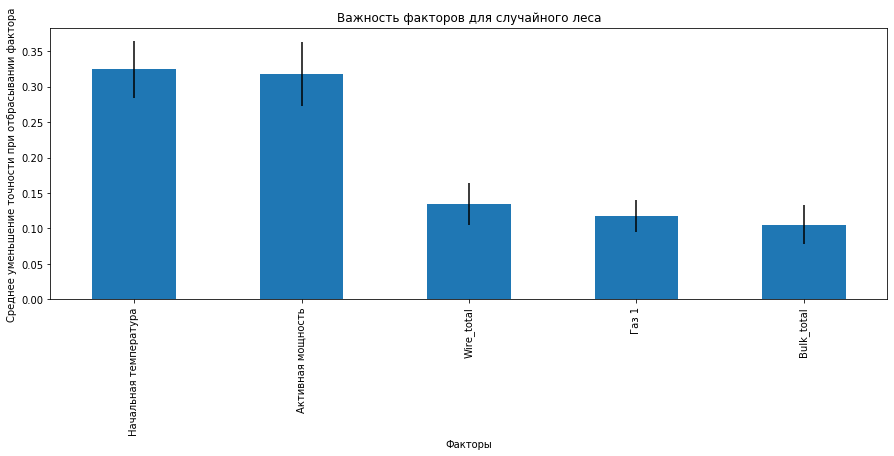

In [19]:
importances = RS_random_forest.best_estimator_.feature_importances_
forest_importances = pd.Series(importances, index=feature_name).sort_values(ascending=False)
std = np.std([
    tree.feature_importances_ for tree in RS_random_forest.best_estimator_.estimators_], axis=0)


plt.figure(figsize=(15, 5))
forest_importances.plot.bar(yerr=std)
plt.title('Важность факторов для случайного леса')
plt.xlabel('Факторы')
plt.ylabel('Среднее уменьшение точности при отбрасывании фактора')
plt.show()

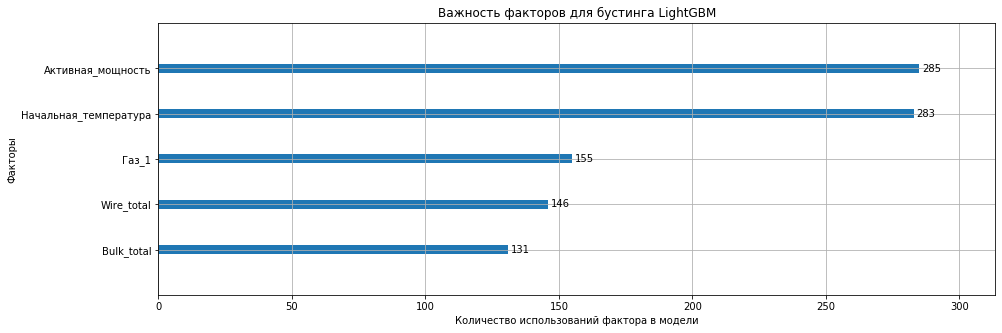

In [20]:
lgb.plot_importance(model_lgb, figsize=(15, 5))
plt.title('Важность факторов для бустинга LightGBM')
plt.ylabel('Факторы')
plt.xlabel('Количество использований фактора в модели')
plt.show()